In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
path = "D:/Gauri/SEM5/ML/week6/linear-regression-thatgauripai/stud_per.csv"   

# We'll parse header normally, then manually parse each data line that is wrapped in quotes
with open(path, 'r', encoding='utf-8') as f:
    header_line = f.readline().strip()
    columns = header_line.split(';')
    rows = []
    for line in f:
        s = line.strip()
        if not s:
            continue
        # remove outer quotes if present
        if s.startswith('"') and s.endswith('"'):
            s = s[1:-1]
        # replace double double-quotes with a single quote char
        s = s.replace('""', '"')
        parts = s.split(';')
        parts = [p.strip().strip('"') for p in parts]
        if len(parts) < len(columns):
            parts += [None] * (len(columns) - len(parts))
        elif len(parts) > len(columns):
            parts = parts[:len(columns)]
        rows.append(parts)

df = pd.DataFrame(rows, columns=columns)

print("Parsed shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(4))

Parsed shape: (395, 33)
Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15


In [3]:
numeric_cols = ['G1', 'G2', 'G3', 'studytime', 'failures', 'age', 'absences']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [4]:
print("\nMissing counts (selected cols):")
display(df[numeric_cols].isnull().sum())



Missing counts (selected cols):


G1           0
G2           0
G3           0
studytime    0
failures     0
age          0
absences     0
dtype: int64

In [5]:
if 'G3' not in df.columns or df['G3'].isnull().all():
    raise RuntimeError("Target column 'G3' not found or contains only NaN. Check CSV parsing.")

In [6]:
for col in numeric_cols:
    if col in df.columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

In [7]:
print("\nDescriptive statistics:")
display(df[numeric_cols].describe().T)


Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
G1,395.0,10.908861,3.319195,3.0,8.0,11.0,13.0,19.0
G2,395.0,10.713924,3.761505,0.0,9.0,11.0,13.0,19.0
G3,395.0,10.415190,4.581443,0.0,8.0,11.0,14.0,20.0
studytime,395.0,2.035443,0.839240,1.0,1.0,2.0,2.0,4.0
failures,395.0,0.334177,0.743651,0.0,0.0,0.0,0.0,3.0
age,395.0,16.696203,1.276043,15.0,16.0,17.0,18.0,22.0
absences,395.0,5.708861,8.003096,0.0,0.0,4.0,8.0,75.0


In [8]:
corr = df[numeric_cols].corr()
print("\nCorrelation matrix (numeric):")
display(corr)


Correlation matrix (numeric):


,G1,G2,G3,studytime,failures,age,absences
G1,1.000000,0.852118,0.801468,0.160612,-0.354718,-0.064081,-0.031003
G2,0.852118,1.000000,0.904868,0.135880,-0.355896,-0.143474,-0.031777
G3,0.801468,0.904868,1.000000,0.097820,-0.360415,-0.161579,0.034247
studytime,0.160612,0.135880,0.097820,1.000000,-0.173563,-0.004140,-0.062700
failures,-0.354718,-0.355896,-0.360415,-0.173563,1.000000,0.243665,0.063726
age,-0.064081,-0.143474,-0.161579,-0.004140,0.243665,1.000000,0.175230
absences,-0.031003,-0.031777,0.034247,-0.062700,0.063726,0.175230,1.000000


In [9]:
print("\nTop correlations with G3 (by absolute value):")
display(corr['G3'].abs().sort_values(ascending=False))


Top correlations with G3 (by absolute value):


G3           1.000000
G2           0.904868
G1           0.801468
failures     0.360415
age          0.161579
studytime    0.097820
absences     0.034247
Name: G3, dtype: float64

In [10]:
simple_feature = ['G1']                     # common, strong predictor
multiple_features = ['G1', 'G2', 'studytime', 'failures']


In [11]:
for c in simple_feature + multiple_features + ['G3']:
    if c not in df.columns:
        raise RuntimeError(f"Required column '{c}' not found in parsed data.")

model_df = df[[*multiple_features, 'G3']].copy()

In [12]:
for c in model_df.columns:
    if model_df[c].isnull().any():
        model_df[c] = model_df[c].fillna(model_df[c].median())

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error
split_settings = {'80:20': 0.2, '70:30': 0.3, '60:40': 0.4}
results = []

for label, test_size in split_settings.items():
    # Prepare arrays
    X_simple = model_df[simple_feature].values
    X_multi = model_df[multiple_features].values
    y = model_df['G3'].values

    # Split (same random_state for reproducibility)
    Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_simple, y, test_size=test_size, random_state=42)
    Xm_tr, Xm_te, ym_tr, ym_te = train_test_split(X_multi, y, test_size=test_size, random_state=42)

    # OLS simple
    ols_simple = LinearRegression()
    ols_simple.fit(Xs_tr, ys_tr)
    pred_s = ols_simple.predict(Xs_te)

    # OLS multiple
    ols_multi = LinearRegression()
    ols_multi.fit(Xm_tr, ym_tr)
    pred_m = ols_multi.predict(Xm_te)

    # SGD (scaled) on same multi features
    scaler = StandardScaler()
    Xm_tr_s = scaler.fit_transform(Xm_tr)
    Xm_te_s = scaler.transform(Xm_te)
    sgd = SGDRegressor(max_iter=10000, tol=1e-4, random_state=42)
    sgd.fit(Xm_tr_s, ym_tr)
    pred_sgd = sgd.predict(Xm_te_s)

    # Metrics
    def metrics(y_true, y_pred):
        return {
            'R2': r2_score(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred)
        }

    m_s = metrics(ys_te, pred_s)
    m_m = metrics(ym_te, pred_m)
    m_g = metrics(ym_te, pred_sgd)

    results.append({
        'Split': label,
        'Train size': len(ys_tr),
        'Test size': len(ys_te),
        'Simple R2': m_s['R2'], 'Simple MSE': m_s['MSE'], 'Simple MAE': m_s['MAE'],
        'Multi R2': m_m['R2'], 'Multi MSE': m_m['MSE'], 'Multi MAE': m_m['MAE'],
        'SGD R2' : m_g['R2'], 'SGD MSE': m_g['MSE'], 'SGD MAE': m_g['MAE']
    })

    # store return values for 80:20 for plotting
    if label == '80:20':
        plot = {
            'ys_te': ys_te, 'pred_s': pred_s, 'pred_m': pred_m, 'pred_sgd': pred_sgd,
            'ols_simple': ols_simple, 'ols_multi': ols_multi, 'sgd': sgd,
            'scaler': scaler
        }

In [17]:
res_df = pd.DataFrame(results)
print("\nEvaluation results across splits:")
display(res_df.round(4))



Evaluation results across splits:


,Split,Train size,Test size,Simple R2,Simple MSE,Simple MAE,Multi R2,Multi MSE,Multi MAE,SGD R2,SGD MSE,SGD MAE
0,80:20,316,79,0.6995,6.1627,1.8553,0.7817,4.4761,1.2916,0.7813,4.4852,1.3011
1,70:30,276,119,0.6971,6.6593,1.8312,0.7991,4.4159,1.2719,0.7992,4.4145,1.2731
2,60:40,237,158,0.7009,6.5674,1.8208,0.8124,4.1189,1.2444,0.8124,4.1195,1.2427


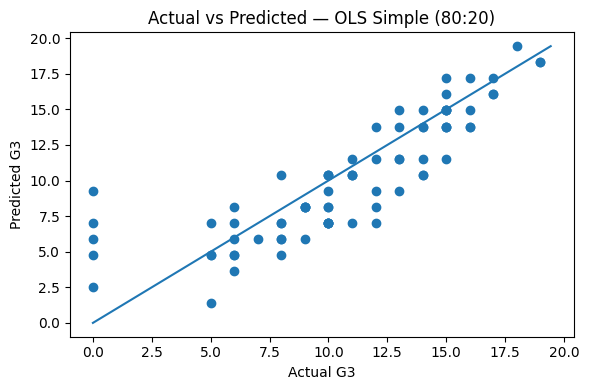

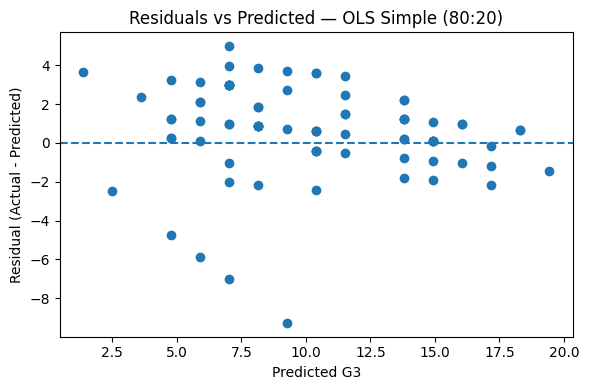

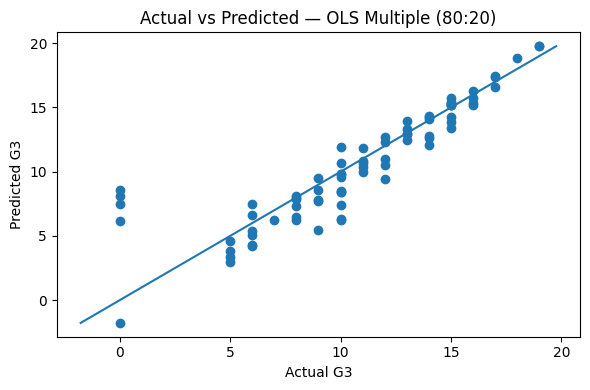

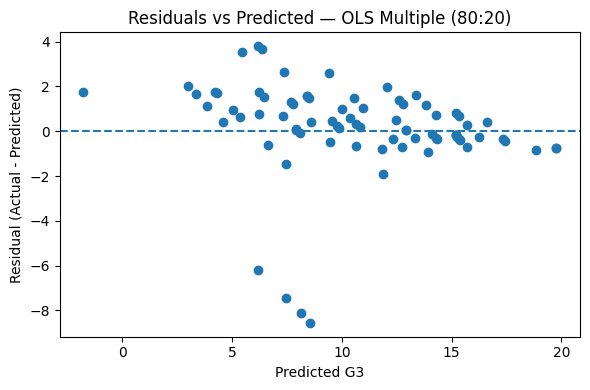

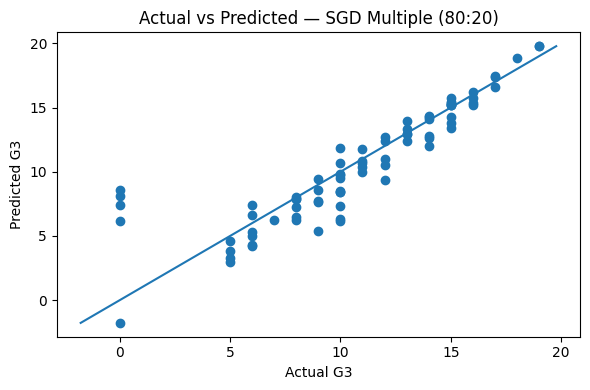

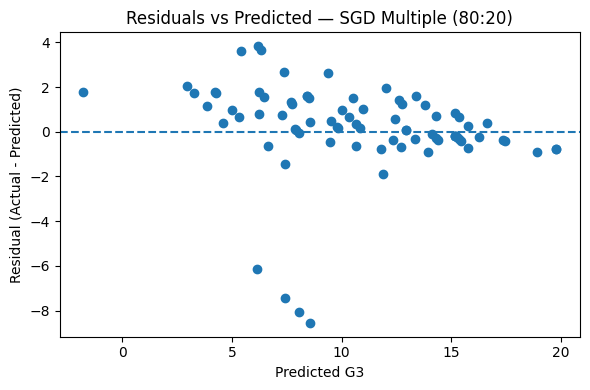

In [18]:
ys_te = plot['ys_te']
for name, preds in [('OLS Simple', plot['pred_s']),
                    ('OLS Multiple', plot['pred_m']),
                    ('SGD Multiple', plot['pred_sgd'])]:
    plt.figure(figsize=(6,4))
    plt.scatter(ys_te, preds)
    mn = min(ys_te.min(), preds.min())
    mx = max(ys_te.max(), preds.max())
    plt.plot([mn, mx], [mn, mx])      # perfect prediction line
    plt.title(f"Actual vs Predicted — {name} (80:20)")
    plt.xlabel("Actual G3")
    plt.ylabel("Predicted G3")
    plt.tight_layout()
    plt.show()

    residuals = ys_te - preds
    plt.figure(figsize=(6,4))
    plt.scatter(preds, residuals)
    plt.axhline(0, linestyle='--')
    plt.title(f"Residuals vs Predicted — {name} (80:20)")
    plt.xlabel("Predicted G3")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.tight_layout()
    plt.show()

In [19]:
print("\nOLS simple (G1 -> G3) intercept and coef:")
print(plot['ols_simple'].intercept_, plot['ols_simple'].coef_)

print("\nOLS multiple intercept and coefficients (features = {}):".format(multiple_features))
print(plot['ols_multi'].intercept_, plot['ols_multi'].coef_)

print("\nSGD (scaled) intercept and coefficients (correspond to scaled features):")
print(plot['sgd'].intercept_, plot['sgd'].coef_)


OLS simple (G1 -> G3) intercept and coef:
-2.023897246210092 [1.12953735]

OLS multiple intercept and coefficients (features = ['G1', 'G2', 'studytime', 'failures']):
-1.3800633518898557 [ 0.14624272  0.9787659  -0.08258531 -0.44586729]

SGD (scaled) intercept and coefficients (correspond to scaled features):
[10.31871397] [ 0.51411787  3.63456047 -0.07083549 -0.32929955]


In [20]:
print("\nInference summary:")
print("- Multiple OLS using [G1, G2, studytime, failures] typically performs better than the simple single-feature OLS (check higher R² and lower MSE/MAE).")
print("- SGDRegressor (with scaling) attains similar performance to OLS on this dataset; benefits include streaming / large-data handling and easier regularization.")
print("- Metrics can vary with different train/test splits; check consistency across splits for stability.")
print("- Residual plots help check assumptions — ideally residuals scatter randomly around zero (no strong pattern).")
print("\nIf you want: (a) I can run cross-validation, (b) tune SGD hyperparameters (learning rate, regularization), (c) add more features or encoding of categorical variables, or (d) prepare a downloadable notebook with these results.")


Inference summary:
- Multiple OLS using [G1, G2, studytime, failures] typically performs better than the simple single-feature OLS (check higher R² and lower MSE/MAE).
- SGDRegressor (with scaling) attains similar performance to OLS on this dataset; benefits include streaming / large-data handling and easier regularization.
- Metrics can vary with different train/test splits; check consistency across splits for stability.
- Residual plots help check assumptions — ideally residuals scatter randomly around zero (no strong pattern).

If you want: (a) I can run cross-validation, (b) tune SGD hyperparameters (learning rate, regularization), (c) add more features or encoding of categorical variables, or (d) prepare a downloadable notebook with these results.
